# Introduction

The multi-objective problem arises frequently in experimental campaigns.
Consider the following example. Suppose you are synthesizing nanoparticles (NP)
in solution with respect to two experimental parameters: synthesis temperature
$T$ and some precursor concentration $c$. The result is a population of NPs of
various sizes (as measured by NP radius). This population results in an average
radius $r$ and a polydispersity $\sigma$ given by the standard deviation of the
NP radius distribution.

Your objective is to identify the optimal synthesis parameters $x = (T, c)$ that
result in NPs with 1) a specific average radius target $r^\star$ and 2) minimal
NP size polydispersity. This is an example of a multi objective problem, namely
two objectives: targeting of $r$, and minimization of $\sigma$.

We can treat the observed NP average radius and polydispersity as functions of
synthesis conditions $x$, writing $r(x)$ and $\sigma(x)$. For any given $x$, we
assume that we can make *noisy observations*:

\begin{align}
\hat r(x) &= r(x) + W_r, \\
\hat \sigma(x) &= \sigma(x) + W_\sigma,
\end{align}

where $W_r$ and $W_\sigma$ are additive Gaussian noise with known variance (we
know the size of the noise in our observations). (In reality, $\hat \sigma$ is
better represented with a Gamma distribution, here we'll assume Gaussian for
simplicity.) We also assume a correlation between $r$ and $\sigma$: populations with small
and large average radii have small polydispersity, whereas populations with
medium average radii have large polydispersity.

Below, we make a few attempts at modeling this situation and solving the
multi-objective problem, and then compare the various attempts with respect
to some performance metrics.

## Data generation
First, we'll define the ground truth *in silico* in lieu of actually running
experiments, then use the ground truth to generate some data. Below we define
this ground truth, and sample parameters for this ground truth.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import itertools

SEED = 1234
RNG = np.random.default_rng(seed=SEED)
FEATURIZER = PolynomialFeatures(degree=2)

def f_truth(x, params):
    X = FEATURIZER.fit_transform(x)
    r = X @ params['theta'] # radius
    p = (r - params['r_min'])/(params['r_max'] - params['r_min'])
    sigma = -1.0*params['sigma_0'] * p * np.log(p+1e-6)/(1e-1+x[:,0]) # polydispersity
    return r, sigma

def sample_parameters(x):
    X = FEATURIZER.fit_transform(x)
    X_med = np.mean(X, axis = 0)
    theta = RNG.uniform(low=0, high=1/X_med) # sample coefficients
    r = X @ theta # model predictions of radius, use to define reset of params
    r_min = np.min(r)
    r_max = np.max(r)
    sigma_0 = 2*np.std(r)
    return {'theta': theta, 'r_min': r_min, 'r_max': r_max, 'sigma_0': sigma_0}

# The query set of experimental inputs
D = 50
temp_query, conc_query = np.linspace(0, 1, num=D), np.linspace(0, 1, num=D)
x_query = np.array(list(itertools.product(temp_query, conc_query))) # all combos

# Sample the parameters for ground truth
true_params = sample_parameters(x_query)

Now we can evaluate the ground truth at various synthesis conditions and plot
the output variables. We can also form experimentally observed data set by
adding noise to these evaluations of the ground truth.

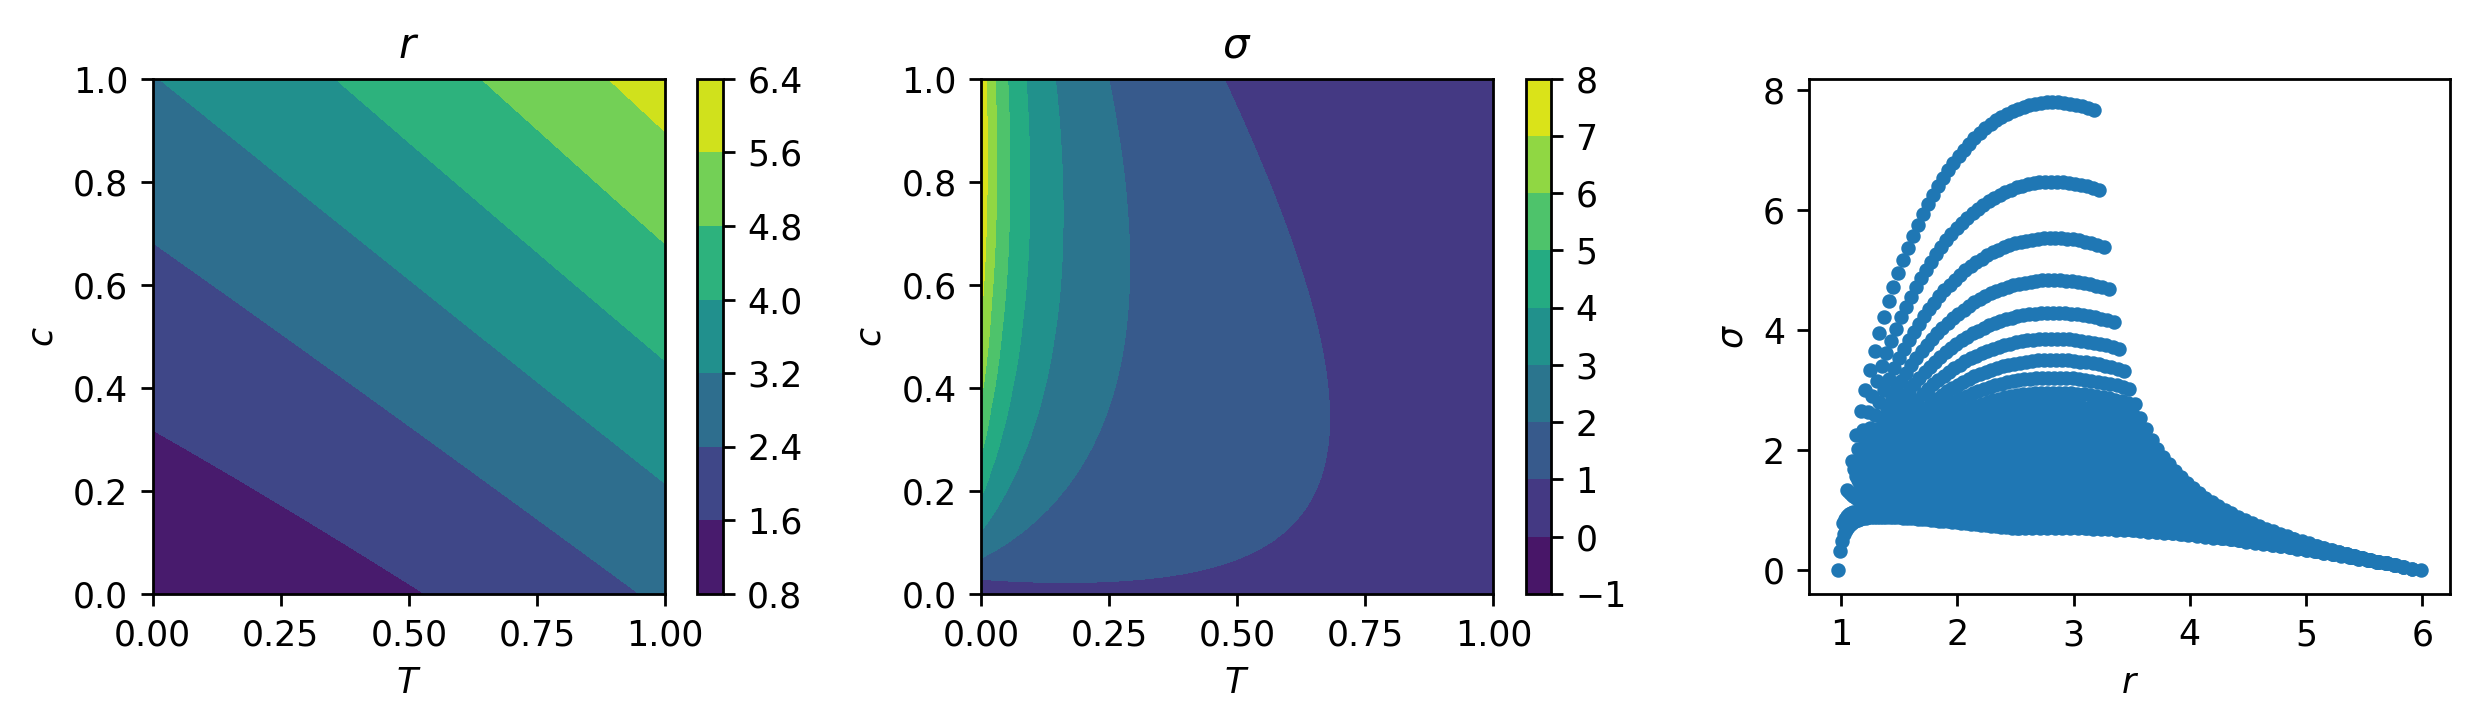

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 250

# Evaluate the ground truth at each of the query points
r_query, sigma_query = f_truth(x_query, true_params)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.contourf(x_query[:,0].reshape(D, D), x_query[:,1].reshape(D, D),
             r_query.reshape(D, D))
plt.colorbar()
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')
plt.title(r'$r$')

plt.subplot(1,3,2)
plt.contourf(x_query[:,0].reshape(D, D), x_query[:,1].reshape(D, D),
             sigma_query.reshape(D, D))
plt.colorbar()
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')
plt.title(r'$\sigma$')

plt.subplot(1,3,3)
plt.scatter(r_query, sigma_query, s=10)
plt.xlabel(r'$r$')
plt.ylabel(r'$\sigma$')
plt.tight_layout()

## Generating training data

Once we have sampled a ground truth, we can generate some data to serve as
training data for the models below. In reality, this data would be obtained
experimentally, but here we can just call the ground-truth function -- and add
some experimental noise.

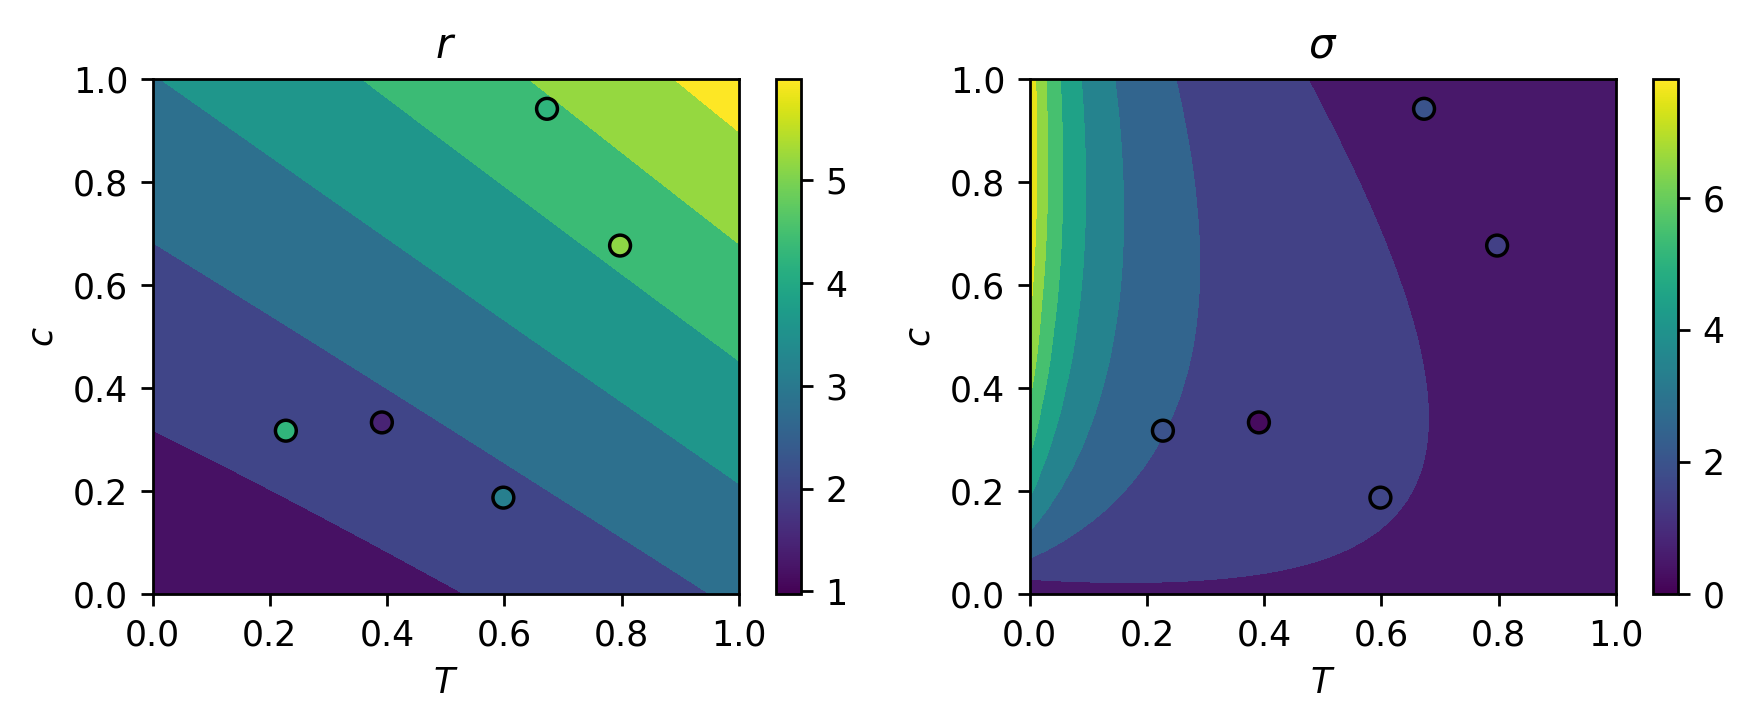

In [103]:
SIGMA_R = 1
SIGMA_S = 1
NUM_DATA = 5

SEED = 12345

rng = np.random.default_rng(seed=SEED)

# Evaluate ground truth at randomly selected inputs
x_data = rng.uniform(low=[0,0], high=[1,1], size=(NUM_DATA,2))
r_data, sigma_data = f_truth(x_data, true_params)

# add noise
r_data = r_data + rng.normal(scale=SIGMA_R, size=r_data.shape)
sigma_data = sigma_data + rng.normal(scale=SIGMA_S, size=sigma_data.shape)

# Plot data

def plot_data_and_truth(x_data, x_query, y_data, y_query,
                        y_min = None, y_max = None):

    # min/max for consistent coloring between scatter and contour plots
    y_all = y_query if y_data is None else np.hstack((y_data, y_query))
    if y_min is None:
        y_min = np.min(y_all)
    if y_max is None:
        y_max = np.max(y_all)

    # plot ground truth and data
    plt.contourf(x_query[:,0].reshape(D, D), x_query[:,1].reshape(D, D),
                 y_query.reshape(D, D), vmin=y_min, vmax=y_max)

    if y_data is not None:
        plt.scatter(x_data[:,0], x_data[:,1], c = y_data, edgecolor='k',
                    vmin=y_min, vmax=y_max)
    plt.colorbar()
    plt.xlabel(r'$T$')
    plt.ylabel(r'$c$')

plt.figure(figsize=(7.25,3))
plt.subplot(1,2,1)
plot_data_and_truth(x_data, x_query, r_data, r_query)
plt.title(r'$r$')

plt.subplot(1,2,2)
plot_data_and_truth(x_data, x_query, sigma_data, sigma_query)
plt.title(r'$\sigma$')

plt.tight_layout()

# Method 1

Suppose we wish to target $r^\star = 3.0$ nm. We can define a utility function

$$z(x) = (1-\alpha)\cdot(r(x)-3.0)^2 + \alpha\cdot\sigma(x)^2,$$

for a tunable paramter $\alpha$ between 0 and 1. This scalarizing utility
function is a simple way of converting the multi-objective problem into a
single-objective problem. With this single objective problem, we can attempt
to use off-the-shelf tools, such as a GP model to estimate $z(x)$, and some
standard policies. Below, we set up a call to Holmes to obtain some experimental
suggestions with these modeling choices.

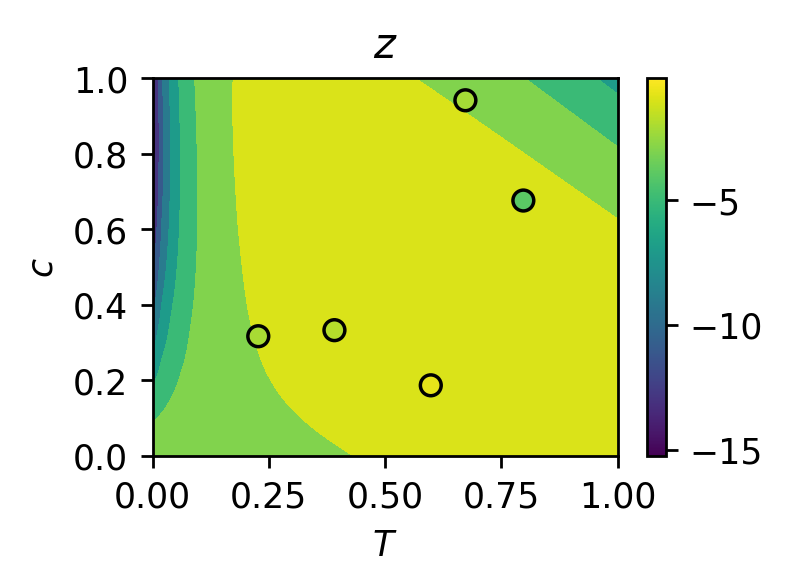

In [104]:
ALPHA = 0.25
R_TARGET = 3.0

z_query =-1.0*( (1 - ALPHA)*(r_query - R_TARGET)**2 + ALPHA*sigma_query**2)
z_data = -1.0*( (1 - ALPHA)*(r_data - R_TARGET)**2 + ALPHA*sigma_data**2)

plt.figure(figsize=(3,2))
plot_data_and_truth(x_data, x_query, z_data, z_query)
plt.title(r'$z$')

data = np.hstack((x_data, z_data[:, np.newaxis]))

In [105]:
import requests
import pprint

BASE_URL = "http://127.0.0.1:5000/holmes"
res = requests.post(BASE_URL + "/basic/suggest", json = data.tolist()).json()
pprint.pprint(res)


{'suggestions': [{'policy': 'xplt',
                  'suggestion': [[0.5948519980274272, 0.18839538215665735]]},
                 {'policy': 'maxvar',
                  'suggestion': [[0.22733602246716966, 0.9230716708610411]]},
                 {'policy': 'mcei',
                  'suggestion': [[0.5233598523903256, 0.22436584036310303]]}]}


### Plotting model predictions


In [107]:
request = {
    "data_raw": data.tolist(),
    "query_list": x_query.tolist(),
    "return_bounds": True
}
res = requests.post(BASE_URL + "/basic/predict", json = request).json()

Plotting the predictions from holmes:

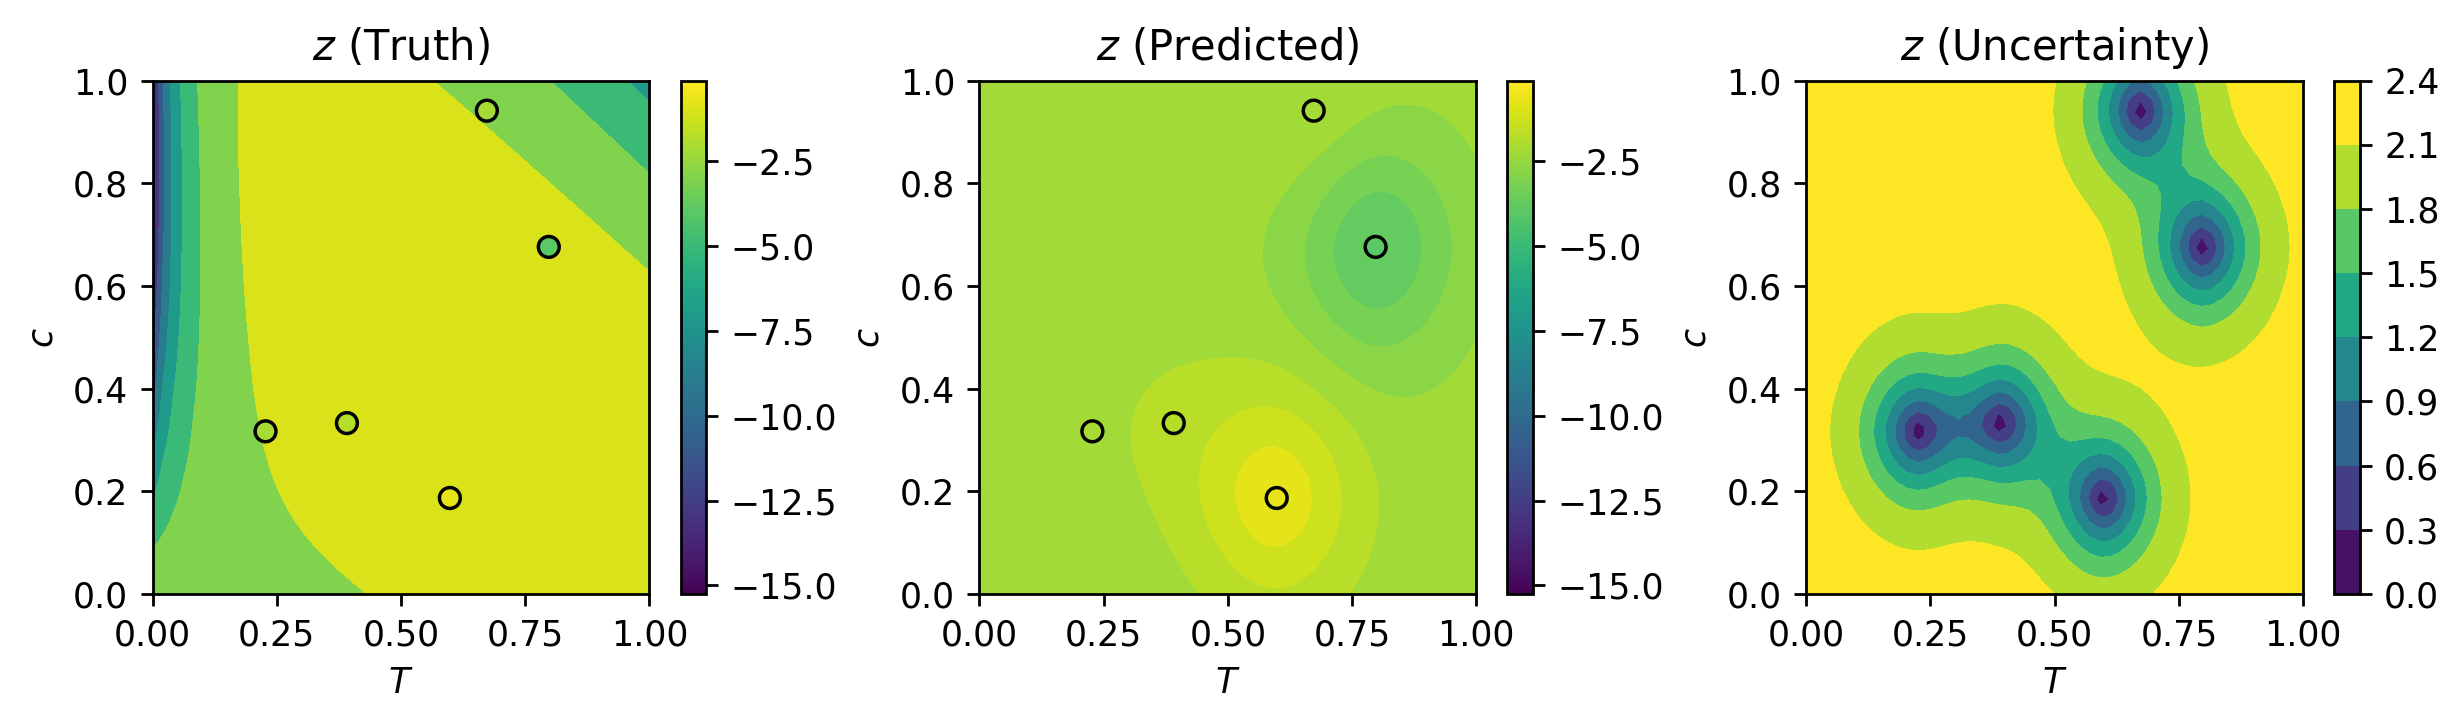

In [108]:
z_model = np.array(res['predictions'])[:,0]
sig_z_model = (np.array(res['upper']) - np.array(res['lower']))[:, 0]

z_min = np.min(np.hstack((z_model, z_data, z_query)))
z_max = np.max(np.hstack((z_model, z_data, z_query)))

# Plot results versus ground truth
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plot_data_and_truth(x_data, x_query, z_data, z_query,
                    y_min = z_min, y_max = z_max)
plt.title(r'$z$ (Truth)')

plt.subplot(1,3,2)
plot_data_and_truth(x_data, x_query, z_data, z_model,
                    y_min = z_min, y_max = z_max)
plt.title(r'$z$ (Predicted)')

plt.subplot(1,3,3)
plot_data_and_truth(x_data, x_query, None, sig_z_model)
plt.title(r'$z$ (Uncertainty)')

plt.tight_layout()


